In [1]:
# download official FVD library - see paper 
!wget https://raw.githubusercontent.com/google-research/google-research/master/frechet_video_distance/frechet_video_distance.py

--2020-06-06 09:45:31--  https://raw.githubusercontent.com/google-research/google-research/master/frechet_video_distance/frechet_video_distance.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5171 (5.0K) [text/plain]
Saving to: ‘frechet_video_distance.py’

frechet_video_dista 100%[===================>]   5.05K  --.-KB/s    in 0s      

2020-06-06 09:45:32 (72.5 MB/s) - ‘frechet_video_distance.py’ saved [5171/5171]



In [1]:
%%bash
gsutil cp  gs://cot-bucket/human_real/moco_ha10000.npz .

Copying gs://cot-bucket/human_real/moco_ha10000.npz...
- [1 files][  1.8 GiB/  1.8 GiB]   87.5 MiB/s                                   
Operation completed over 1 objects/1.8 GiB.                                      


In [38]:
import sys, os
import matplotlib.pyplot as plt
sys.path.append("../")
import numpy as np
import glob
from tqdm.notebook import tqdm
import time
import tensorflow.compat.v1 as tf
import tensorflow_gan as tfgan
from scipy.linalg import sqrtm
import tensorflow_hub as tfhub
import frechet_video_distance as fvd

In [39]:
# load inception net for the computation of FID and KID
inception = tfhub.load('https://tfhub.dev/tensorflow/tfgan/eval/inception/1')

In [40]:
real_data = np.load('ha_real_10000.npz')['arr_0']
moco_data = np.load('moco_ha10000.npz')['arr_0']
cotgan_data = np.load('ha_cot10000.npz')['arr_0']
dm_data = np.load('ha_dm10000.npz')['arr_0']
print(real_data.shape)
print(moco_data.shape)
print(cotgan_data.shape)
print(dm_data.shape)

(10000, 16, 64, 64, 3)
(10000, 16, 64, 64, 3)
(10000, 16, 64, 64, 3)
(10000, 16, 64, 64, 3)


In [41]:
from PIL import Image

def plot_image(data_batch):
    '''
    Args: numpy array of size [batch_size, num_frames, height, width, depth]
    '''
    data_single = data_batch[1, :, :, :, :]
    data_single = np.transpose(data_single, (1, 0, 2, 3))
    data_single = np.reshape(data_single, (64, 16*64, 3))
    data_im = Image.fromarray(np.uint8(data_single))
    return data_im

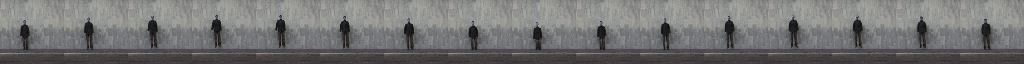

In [42]:
# check shape
plot_image(real_data)

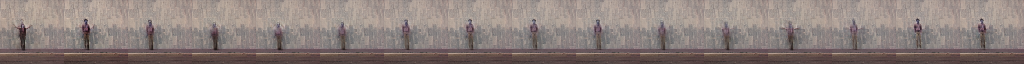

In [43]:
plot_image(cotgan_data)

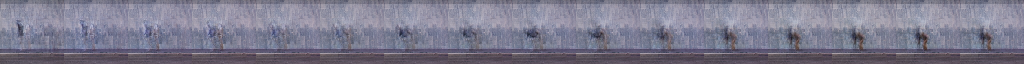

In [44]:
plot_image(dm_data)

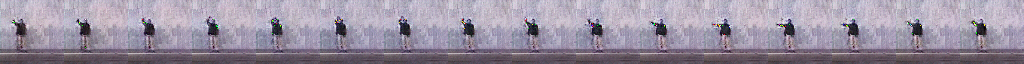

In [45]:
plot_image(moco_data)

In [46]:
print("min of cotgan_data: {}".format(np.min(cotgan_data)))
print("max of cotgan_data: {}".format(np.max(cotgan_data)))
print("min of real_data: {}".format(np.min(real_data)))
print("max of real_data: {}".format(np.max(real_data)))
print("min of moco_data: {}".format(np.min(moco_data)))
print("max of moco_data: {}".format(np.max(moco_data)))
print("min of dm_data: {}".format(np.min(dm_data)))
print("max of dm_data: {}".format(np.max(dm_data)))

min of cotgan_data: 0
max of cotgan_data: 253
min of real_data: 0
max of real_data: 240
min of moco_data: 0
max of moco_data: 255
min of dm_data: 0
max of dm_data: 254


In [47]:
def get_im_features(x, batch_size = 100):
    x = np.float32(x) / 255
    x = x.reshape(x.shape[0] * x.shape[1], x.shape[2], x.shape[3], x.shape[4])
    nbatch = int(np.ceil(x.shape[0] / batch_size))
    out = []
    for i in tqdm(range(nbatch)):
        b = x[i*batch_size : (i+1)*batch_size]
        out += inception(b)["pool_3"].numpy(),
    return np.concatenate(out, 0).squeeze()

def get_vid_features(vid, batch_size):
    # python list to save features
    features = []
    with tf.Graph().as_default():
        videos  = tf.placeholder(tf.float32, [batch_size, VIDEO_LENGTH, 64, 64, 3])
        feature = fvd.create_id3_embedding(fvd.preprocess(videos, (224, 224)))

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())
            n = vid.shape[0]
            nbatch = int(np.floor(n / batch_size))
            
            for i in tqdm(range(nbatch), desc="features"):
                idx = slice(batch_size*i,batch_size*(i+1))
                video_batch = vid[idx]
                actual_batch_size = video_batch.shape[0]

                if actual_batch_size < batch_size:
                    vid_batch = vid[-batch_size:]
                f = sess.run(feature, feed_dict={videos: video_batch})
                features += f[-actual_batch_size:],
    return np.concatenate(features, 0)

def compute_evals(real_act, fake_act):
    fid = tfgan.eval.frechet_classifier_distance_from_activations(
        tf.constant(real_act), tf.constant(fake_act))

    kid = tfgan.eval.kernel_classifier_distance_from_activations(
            tf.constant(real_act), tf.constant(fake_act), max_block_size=1024)
    # return FID/FVD, KID/KVD
    return fid, kid.numpy()

In [48]:
# example for evaluation 
# Number of videos must be divisible by 16.
batch_size = 16
VIDEO_LENGTH = 16
height = 64
width = 64
channels = 3
# compute features for both 
real_features = get_vid_features(real_data, batch_size=batch_size)
cotgan_features = get_vid_features(cotgan_data, batch_size=batch_size)
moco_features = get_vid_features(moco_data, batch_size=batch_size)
dm_features = get_vid_features(dm_data, batch_size=batch_size)
print(real_features.shape)
print(cotgan_features.shape)
print(moco_features.shape)
print(dm_features.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



(10000, 400)
(10000, 400)
(10000, 400)
(10000, 400)


In [49]:
#compute fvd and kvd from features generated from 3Dconv nets
fvd, kvd = compute_evals(real_features, cotgan_features)
print("FVD for COTGAN is", fvd)
print("KVD for COTGAN is", kvd)

FVD for COTGAN is tf.Tensor(463.89508, shape=(), dtype=float32)
KVD for COTGAN is 41.331577


In [50]:
#compute fvd and kvd from features generated from 3Dconv nets
fvd, kvd = compute_evals(real_features, moco_features)
print("FVD for MoCoGAN is", fvd)
print("KVD for MoCoGAN is", kvd)

FVD for MoCoGAN is tf.Tensor(1042.4254, shape=(), dtype=float32)
KVD for MoCoGAN is 88.200485


In [51]:
#compute fvd and kvd from features generated from 3Dconv nets
fvd, kvd = compute_evals(real_features, dm_features)
print("FVD for direct minimisation is", fvd)
print("KVD for direct minimisation is", kvd)

FVD for direct minimisation is tf.Tensor(520.8109, shape=(), dtype=float32)
KVD for direct minimisation is 34.41163


In [52]:
# compute the features from inception net
real_incep_features = get_im_features(real_data, batch_size=100)
cotgan_incep_features = get_im_features(cotgan_data, batch_size=100)
moco_incep_features = get_im_features(moco_data, batch_size=100)
dm_incep_features = get_im_features(dm_data, batch_size=100)
print(real_incep_features.shape)
print(cotgan_incep_features.shape)
print(moco_incep_features.shape)
print(dm_incep_features.shape)


(160000, 2048)
(160000, 2048)
(160000, 2048)
(160000, 2048)


In [53]:
#compute fid and kid from features generated from 3Dconv nets
fid, kid = compute_evals(real_incep_features, cotgan_incep_features)
print("FID for COTGAN is", fid)
print("KID for COTGAN is", kid)

FID for COTGAN is tf.Tensor(59.22109, shape=(), dtype=float32)
KID for COTGAN is 0.046221126


In [54]:
#compute fid and kid from features generated from 3Dconv nets
fid, kid = compute_evals(real_incep_features, moco_incep_features)
print("FID for MoCoGAN is", fid)
print("KID for MoCoGAN is", kid)

FID for MoCoGAN is tf.Tensor(151.66058, shape=(), dtype=float32)
KID for MoCoGAN is 0.1751758


In [55]:
#compute fid and kid from features generated from 3Dconv nets
fid, kid = compute_evals(real_incep_features, dm_incep_features)
print("FID for direct minimisation is", fid)
print("KID for direct minimisation is", kid)

FID for direct minimisation is tf.Tensor(120.509315, shape=(), dtype=float32)
KID for direct minimisation is 0.14744306
